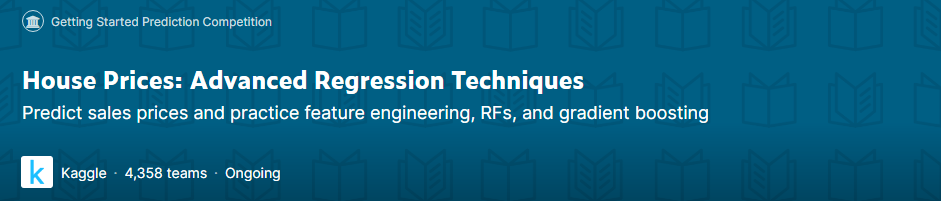

【概要】<br>
・https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview<br>

・80個の特徴量から住宅価格（目的変数）の回帰予測を行うコンペティション<br>

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submit = pd.read_csv('sample_submission.csv')

print(train.shape)
print(test.shape)

(1460, 81)
(1459, 80)


In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [5]:
sample_submit.head()

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


In [6]:
# submit用のインデックスを保存
Id = test['Id']

In [7]:
# trainデータから目的変数を分類
y = train.SalePrice
train = train[[col for col in train.columns if col != 'SalePrice']]

print(train.shape)
print(test.shape)
y[:5]

(1460, 80)
(1459, 80)


0    208500
1    181500
2    223500
3    140000
4    250000
Name: SalePrice, dtype: int64

In [8]:
# trainとtestの特徴量データを結合
X = pd.concat([train, test], axis=0)

print(X.shape)
X.head(5)

(2919, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [9]:
# 全体の欠損
print(X.isnull().sum())
print('total_null:',X.isnull().sum().sum())

Id                 0
MSSubClass         0
MSZoning           4
LotFrontage      486
LotArea            0
                ... 
MiscVal            0
MoSold             0
YrSold             0
SaleType           1
SaleCondition      0
Length: 80, dtype: int64
total_null: 13965


In [10]:
# 数値カラム、文字列カラムを確認
numerical_col = [col for col in X.columns if X[col].dtype != 'object']
categorical_col = [col for col in X.columns if X[col].dtype == 'object']

print(numerical_col[:5])
print(categorical_col[:5])
print(len(numerical_col))
print(len(categorical_col))

['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual']
['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour']
37
43


In [11]:
# 数値カラム、文字列カラムに分離
X_num = X[numerical_col]
X_cat = X[categorical_col]

print(X_num.shape)
print(X_cat.shape)

(2919, 37)
(2919, 43)


In [12]:
# 欠損値の補完
X_num.fillna(X_num.median(), inplace=True)
X_cat.fillna(value='missing', inplace=True)

print(X_num.isnull().sum().sum())
print(X_cat.isnull().sum().sum())

0
0


C:\Users\Owner\anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
C:\Users\Owner\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [13]:
# 文字列カラムにOne-hot-Encoding
X_cat = pd.get_dummies(X_cat)

print(X_num.shape)
print(X_cat.shape)
X_cat.head()

(2919, 37)
(2919, 275)


,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,MSZoning_missing,Street_Grvl,Street_Pave,Alley_Grvl,Alley_Pave,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleType_missing,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,0,1,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
1,0,0,0,1,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
2,0,0,0,1,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
3,0,0,0,1,0,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
4,0,0,0,1,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0


In [14]:
# 数値カラムと文字列カラム（One-hot済み）を結合
X_total = pd.concat([X_num, X_cat], axis=1)

print(X_total.shape)
X_total.head()

(2919, 312)


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleType_missing,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,65.0,8450,7,5,2003,2003,196.0,706.0,...,0,0,1,0,0,0,0,0,1,0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978.0,...,0,0,1,0,0,0,0,0,1,0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486.0,...,0,0,1,0,0,0,0,0,1,0
3,4,70,60.0,9550,7,5,1915,1970,0.0,216.0,...,0,0,1,0,1,0,0,0,0,0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655.0,...,0,0,1,0,0,0,0,0,1,0


In [15]:
train_rows = train.shape[0]
X = X_total[:train_rows]

std = StandardScaler()
X = std.fit_transform(X)

y = y[:train_rows]

print(X.shape)
print(y.shape)

(1460, 312)
(1460,)


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1022, 312)
(1022,)
(438, 312)
(438,)


In [18]:
ridge = Ridge()
ridge.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [19]:
y_pred = ridge.predict(X_test)
print(y_pred[:5])

[210048.02459532  71319.13510634 129977.01768134 260412.74243572
 128557.01302559]


In [24]:
def root_mse(y_test, y_pred):
    return np.sqrt(mean_squared_error(y_test, y_pred))
                   
print(root_mse(y_test, y_pred))

30763.4559810311


In [25]:
X_test_submit = X_total[train_rows:]
X_test_submit = std.fit_transform(X_test_submit)

print(X_train.shape)
print(X_test_submit.shape)

(1022, 312)
(1459, 312)


In [26]:
y_pred_submit = ridge.predict(X_test_submit)
print(y_pred_submit[:5])

[106695.52689762 164826.28607673 188944.78118156 196851.85932193
 194214.28541927]


In [27]:
df_submit = pd.DataFrame(y_pred_submit, Id, columns=['SalePrice'])
df_submit.head()

,SalePrice
Id,
1461,106695.526898
1462,164826.286077
1463,188944.781182
1464,196851.859322
1465,194214.285419


In [28]:
df_submit.to_csv('House_Prices__submit.csv')

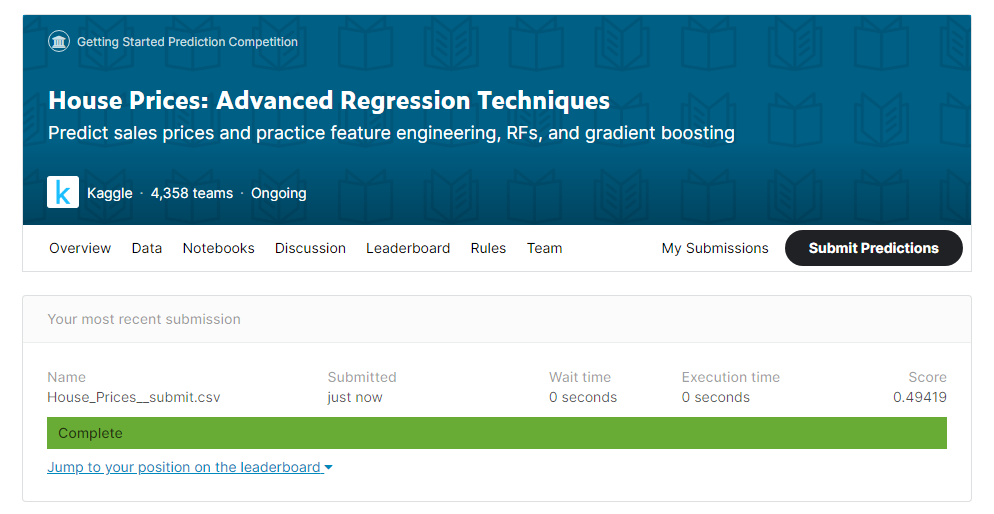